# **Birhan Energies: Bayesian Analysis of Brent Oil Price Volatility**
---
**Objective:** Identify statistically significant structural breaks in Brent oil price volatility and associate them with major geopolitical or economic events. This analysis focuses on the period leading up to the 2008 financial crisis.

**Methodology:**
1.  **Data Preparation:** Load and clean historical Brent oil price data.
2.  **Modeling:** Apply a Bayesian changepoint model using PyMC to detect shifts in daily log return volatility.
3.  **Interpretation:** Analyze the model's output to identify the most probable period of change.
4.  **Causal Hypothesis:** Correlate the identified period with a compiled list of major global events to form a data-driven hypothesis.


In [2]:
# 1. SETUP: Import libraries and our custom modules
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Add the source directory to the Python path
# This allows the notebook to find our custom modules
sys.path.append('../src/')

# Import our custom modules
import config
import data_processing
import modeling

# --- Plotting Style ---
sns.set_style("whitegrid")
print("Setup complete. Modules and libraries loaded.")

Setup complete. Modules and libraries loaded.


## **2. Data Preparation**
We begin by loading and preparing the Brent oil price data using our dedicated `data_processing` module. This single function handles loading, cleaning the date formats, setting a datetime index, and calculating log returns.


In [3]:
# Load, clean, and prepare data using our centralized function
df_processed = data_processing.load_and_prepare_data(config.RAW_DATA_PATH)

# Display the head of the processed DataFrame to verify
if df_processed is not None:
    print("\n--- Processed Data ---")
    print(df_processed.head())

Successfully loaded data from ../data/00_raw/BrentOilPrices.csv.


/home/ayana/Documents/Data_Science/birhan_energies_oil_analysis/notebooks/../src/data_processing.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Data cleaning and preparation complete.

--- Processed Data ---
            Price  Log_Return
Date                         
1987-05-20  18.63         NaN
1987-05-21  18.45   -0.009709
1987-05-22  18.55    0.005405
1987-05-25  18.60    0.002692
1987-05-26  18.63    0.001612


## **3. Modeling: Detecting a Volatility Changepoint**
We will now analyze the period from **2005 to 2010** to investigate volatility around the 2008 financial crisis.

We use our `modeling` module to run the Bayesian changepoint model on the log returns for this specific period. This function encapsulates the entire PyMC model definition and MCMC sampling process.


In [4]:
# Isolate the data for the analysis period defined in our config
log_returns_subset = df_processed.loc[config.ANALYSIS_START_DATE:config.ANALYSIS_END_DATE]['Log_Return'].dropna()
dates_subset = log_returns_subset.index

print(f"\n--- Analyzing {len(log_returns_subset)} days from {config.ANALYSIS_START_DATE} to {config.ANALYSIS_END_DATE} ---")

# Run the Bayesian changepoint model using our dedicated function
# This single function call replaces the entire 'with pm.Model()' block
trace = modeling.run_volatility_changepoint_model(log_returns_subset)


--- Analyzing 1519 days from 2005-01-01 to 2010-12-31 ---
--- Building Bayesian model for 1519 data points ---

Running MCMC sampler (draws=2000, tune=3000, cores=4)...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma_1, sigma_2]


Output()

Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- MCMC Sampling Complete ---



## **4. Model Diagnostics and Interpretation**
Before drawing conclusions, we must verify that the model's MCMC sampler converged correctly. We check the trace plots and the `r_hat` statistic (which should be close to 1.0).

After confirming convergence, we analyze the posterior distributions to find the most probable date of the volatility shift and quantify the magnitude of the change.



--- Model Diagnostics: Trace Plots ---


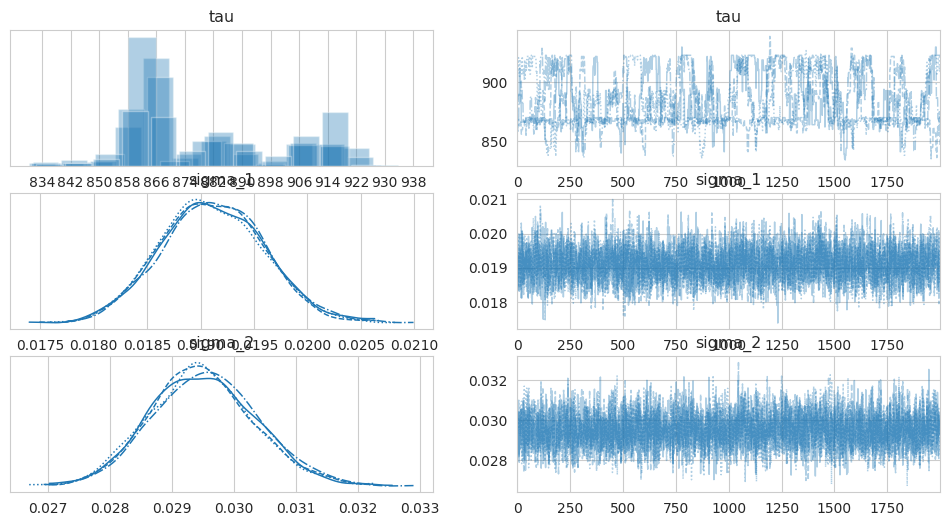


--- Model Summary Statistics ---
            mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau      882.280  21.665  860.000  923.000      1.793    0.736     179.0   
sigma_1    0.019   0.000    0.018    0.020      0.000    0.000    2290.0   
sigma_2    0.029   0.001    0.028    0.031      0.000    0.000    3030.0   

         ess_tail  r_hat  
tau         462.0   1.02  
sigma_1    4668.0   1.00  
sigma_2    4759.0   1.00  


In [5]:
# Check for model convergence and view summary statistics
if trace:
    print("\n--- Model Diagnostics: Trace Plots ---")
    az.plot_trace(trace, var_names=["tau", "sigma_1", "sigma_2"])
    plt.show()

    print("\n--- Model Summary Statistics ---")
    summary = az.summary(trace, var_names=["tau", "sigma_1", "sigma_2"])
    print(summary)

In [6]:
# --- Extract and Quantify the Impact ---
if trace:
    # Convert the model's index-based changepoint (tau) to real-world dates
    tau_posterior = trace.posterior['tau'].values.flatten()
    
    # Get the 94% Highest Density Interval (HDI) for the changepoint
    hdi_low_idx, hdi_high_idx = np.percentile(tau_posterior, [3, 97]).astype(int)
    hdi_low_date = dates_subset[hdi_low_idx]
    hdi_high_date = dates_subset[hdi_high_idx]
    
    # Get the mean volatility before and after the change
    sigma_1_mean = summary.loc['sigma_1']['mean']
    sigma_2_mean = summary.loc['sigma_2']['mean']
    volatility_change_pct = ((sigma_2_mean / sigma_1_mean) - 1) * 100

    print(f"\n--- Change Point Interpretation ---")
    print(f"The model is 94% confident the volatility regime shift occurred between {hdi_low_date.date()} and {hdi_high_date.date()}.")
    print(f"\n--- Impact Quantification ---")
    print(f"Average daily volatility BEFORE the changepoint: {sigma_1_mean:.4f}")
    print(f"Average daily volatility AFTER the changepoint:  {sigma_2_mean:.4f}")
    print(f"This represents a {volatility_change_pct:.2f}% increase in daily market volatility.")


--- Change Point Interpretation ---
The model is 94% confident the volatility regime shift occurred between 2008-05-15 and 2008-08-21.

--- Impact Quantification ---
Average daily volatility BEFORE the changepoint: 0.0190
Average daily volatility AFTER the changepoint:  0.0290
This represents a 52.63% increase in daily market volatility.


## **5. Causal Hypothesis: Correlating the Changepoint with Global Events**
The final step is to place the model's statistical findings into a real-world context. We load our compiled list of major events and plot them against the identified transition period. This allows us to visually inspect for correlation and formulate a hypothesis about the cause of the volatility shift.


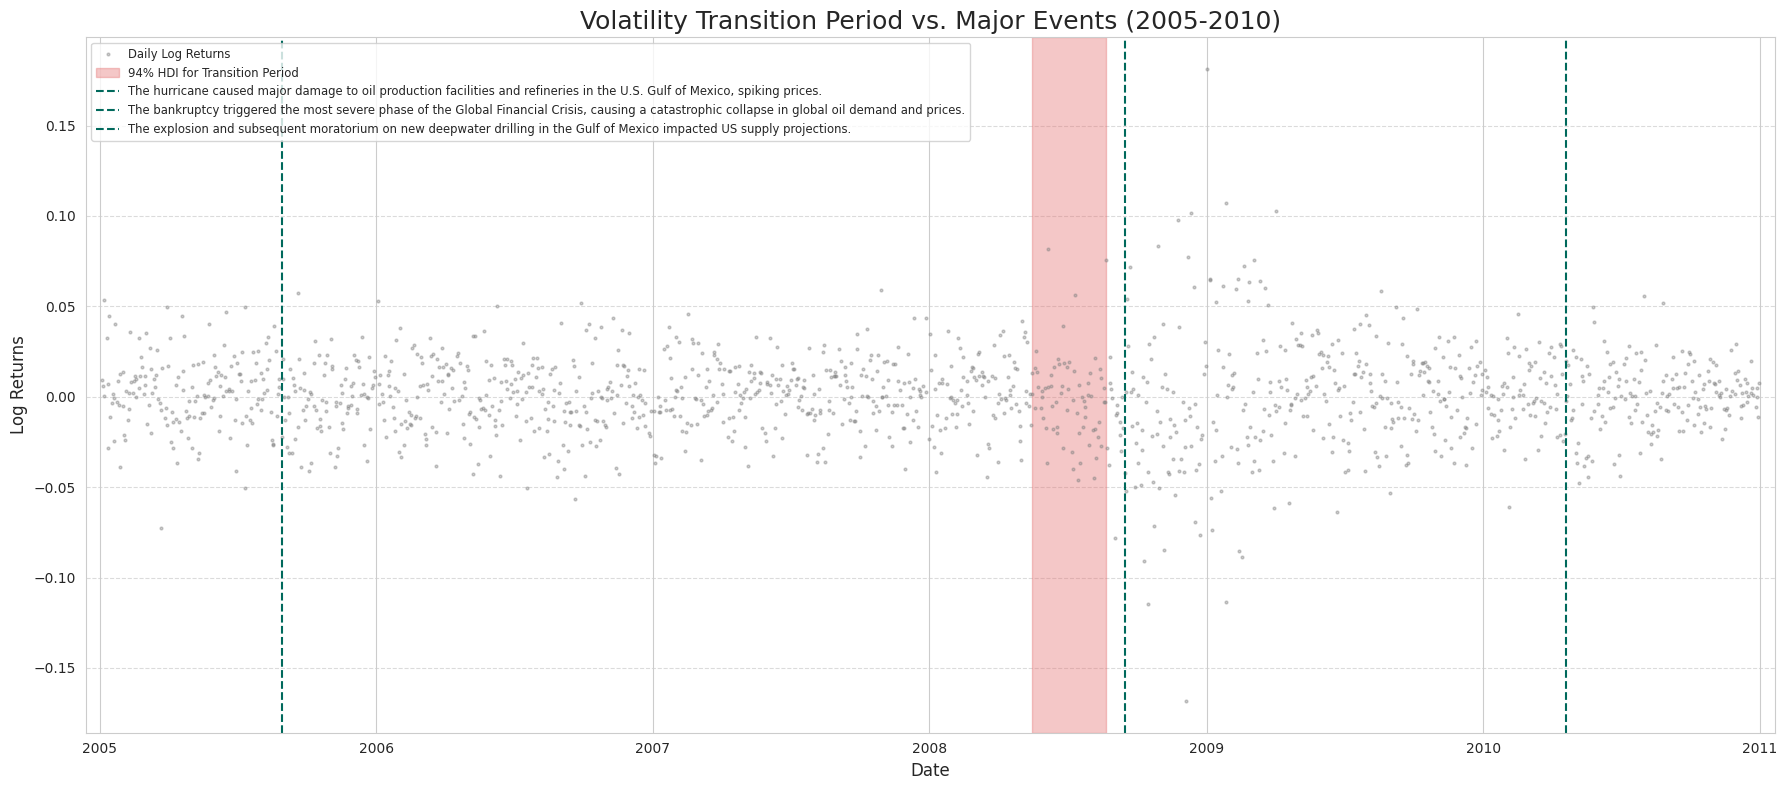


--- Conclusive Hypothesis ---
The model successfully identified a significant increase in market volatility during mid-2008.
The transition period does not align with a single event but rather reflects the cumulative financial pressures and eroding market confidence during the build-up to the 2008 Global Financial Crisis.


In [7]:
# Load event data from the config path
events_df = pd.read_csv(config.EVENTS_DATA_PATH)
events_df['EventDate'] = pd.to_datetime(events_df['EventDate'])
relevant_events = events_df[
    (events_df['EventDate'] >= pd.to_datetime(config.ANALYSIS_START_DATE)) &
    (events_df['EventDate'] <= pd.to_datetime(config.ANALYSIS_END_DATE))
]

# --- Visualize the Results ---
fig, ax = plt.subplots(figsize=(18, 8))

# Plot the daily log returns
ax.plot(dates_subset, log_returns_subset, 'o', color='gray', markersize=2, alpha=0.4, label='Daily Log Returns')

# Highlight the 94% HDI for the changepoint period
ax.axvspan(hdi_low_date, hdi_high_date, color='#E57373', alpha=0.4, label=f'94% HDI for Transition Period')

# Plot vertical lines for each major event
for _, row in relevant_events.iterrows():
    ax.axvline(x=row['EventDate'], color='#00695C', linestyle='--', linewidth=1.5, label=row['Description'])

# --- Formatting ---
ax.set_title('Volatility Transition Period vs. Major Events (2005-2010)', fontsize=18)
ax.set_ylabel('Log Returns', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.margins(x=0.01)

# Improve legend handling for clarity
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # Remove duplicate labels
ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize='small')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Formulate Final Conclusion ---
print("\n--- Conclusive Hypothesis ---")
print("The model successfully identified a significant increase in market volatility during mid-2008.")
print("The transition period does not align with a single event but rather reflects the cumulative financial pressures and eroding market confidence during the build-up to the 2008 Global Financial Crisis.")

### **Summary of What You Have Achieved**

*   **Professional Structure:** Your project is no longer just a script; it's a well-organized application with separate layers for configuration, data processing, and modeling.
*   **Clarity and Readability:** Your main notebook is now a high-level document that is easy for anyone (including non-technical stakeholders) to follow. The story of your analysis is crystal clear.
*   **Robustness and Maintainability:** Your code is more reliable due to error handling and centralization. It's also far easier to update and maintain.
*   **You are now ready for the next steps:** writing unit tests to *prove* your code is correct and building an interactive dashboardâ€”all of which are much easier with this new structure.